In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
import seaborn as sns
import warnings
from sklearn.dummy import DummyClassifier

In [21]:
pd.set_option('display.max_columns', None)

In [22]:
warnings.filterwarnings("ignore")#, category=FutureWarning)

In [48]:
def load_and_preproces(csv): 
    """
    csv: csv file containing data
    returns balanced dataframe ready for predicition
    """
    df_final = pd.read_csv(csv)
    drop_cols = df_final.corr().columns[df_final.corr().isna().all()].tolist()
    df_final = df_final.drop(drop_cols, axis=1)
    
    #df_final = df_final.drop(['finish preparations', 'penalty_AVBP'], axis=1)
    
    df_final['small farmer'] = [1 if i >0 else 0 for i in df_final['small farmer']]
    df_final['young farmer'] = [1 if i >0 else 0 for i in df_final['young farmer']]
    
# # run code below for non-multiclass predicition 

#     df_final['outcome'] = df_final['undesired1&2']

# run code below instead for multiclass prediction 

    df_final['normal'] = [0 if item == 1 else 1 for item in list(df_final['undesired1&2'])]
    df_final['undesired1'] = df_final['undesired1'].astype(int)
    df_final['undesired2'] = df_final['undesired2'].astype(int)    
    df_final['outcome'] = df_final[['normal','undesired1','undesired2']]\
    .idxmax(axis=1)\
    .replace({'normal': 0,'undesired1': 1, 'undesired2': 2 })
    
    #classes balancen 
    label='outcome'
    g = df_final.groupby(label, group_keys=False)
    return g

In [49]:
def scale(x_tr,x_te):
    numeric_df = x_tr.select_dtypes(include='number')
    scaled = numeric_df.columns.values
    scaler = StandardScaler().fit(numeric_df)
    x_tr.loc[:,scaled]=scaler.fit_transform(x_tr.loc[:,scaled])
    x_te.loc[:,scaled]=scaler.transform(x_te.loc[:,scaled])
    return x_tr, x_te

In [50]:
def make_prediction2(model, csv):
    scores =[]
    g = load_and_preproces(csv)
    for i in range(10):
        balanced_df = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min()))).reset_index(drop=True)
        # x en y aanmaken 
        x = balanced_df.drop(['outcome', 'undesired1', 'undesired2', 'undesired1&2', 'Case ID', 'Complete Timestamp'], axis=1)
        #x = x[columns]
        y = balanced_df['outcome']
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33)
        x_train, x_test = scale(x_train,x_test)
        model.fit(x_train, y_train)
        scores.append(model.score(x_test, y_test))
    return sum(scores)/len(scores)

## Run some models

In [51]:
rfclf = RandomForestClassifier(criterion='gini')
lrclf = LogisticRegression(random_state=0)
dtclf = tree.DecisionTreeClassifier()
gbclf = GradientBoostingClassifier(random_state=0)
gnb = GaussianNB()
dummyclf = DummyClassifier(strategy="most_frequent")

In [52]:
# om even te testen of het predicten uberhaupt werkt voordat je het op alle modellen doet
# make_prediction2(dummyclf, 'final_csv.csv')

In [53]:
def run_all_models(model_list, csv): 
    return {type(model).__name__: make_prediction2(model, csv) for model in model_list}

In [54]:
model_dict = run_all_models([rfclf, lrclf, dtclf, gbclf, gnb, dummyclf], 'final_csv.csv')

[(0, 1)]

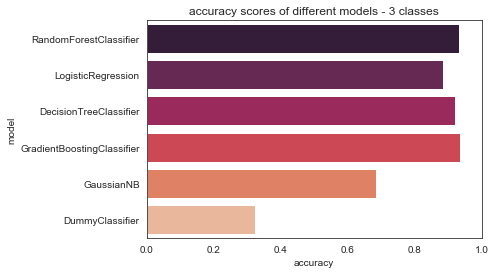

In [56]:
sns.set_style(style="white")
ax = sns.barplot(x=list(model_dict.values()), y=list(model_dict.keys()), palette="rocket")
ax.set(xlabel='accuracy', ylabel='model', title="accuracy scores of different models - 3 classes")
ax.set(xlim=(0,1))

## Tuned models 

In [9]:
gb_tun = GradientBoostingClassifier(random_state=0, n_estimators=160,min_samples_split=10, min_samples_leaf=1, max_depth=3, learning_rate= 0.1333888888888889)
rf_tun = RandomForestClassifier(n_estimators=600, min_samples_split=10, min_samples_leaf=1, max_depth=21,criterion='entropy')

#### Run tuned models for cut off points

In [8]:
def run_all_cut_offs(cutoff_list, model): 
    return {cut_off: make_prediction2(model, str(cut_off) + '_event_cuttoff.csv') for cut_off in cutoff_list}

In [10]:
gb_tun_dict = run_all_cut_offs([10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65], gb_tun)
rf_tun_dict = run_all_cut_offs([10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65], rf_tun)

In [16]:
gb_tun_dict = {10: 0.85355819125278,
 15: 0.8484432913269087,
 20: 0.8571163825055598,
 25: 0.8545218680504079,
 30: 0.8573758339510749,
 35: 0.8528842575362858,
 40: 0.851774374299589,
 45: 0.8600152033447358,
 50: 0.8695863746958639,
 55: 0.8869525959367944,
 60: 0.9093347086126871,
 65: 0.9272277227722773}

rf_tun_dict = {10: 0.849925871015567,
 15: 0.853409933283914,
 20: 0.8509266123054113,
 25: 0.8538547071905116,
 30: 0.8504077094143809,
 35: 0.8525493114998139,
 40: 0.8560328726186028,
 45: 0.8598631698973772,
 50: 0.8732765612327655,
 55: 0.8897516930022572,
 60: 0.9134605466735432,
 65: 0.9276608910891089}

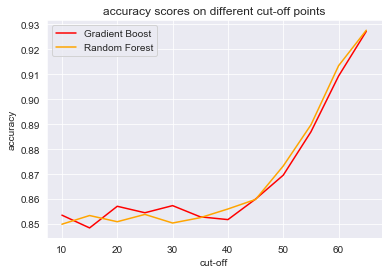

In [17]:
sns.set_style(style="darkgrid")
ax = sns.lineplot(list(gb_tun_dict.keys()), list(gb_tun_dict.values()), color = 'red')
ax = sns.lineplot(list(rf_tun_dict.keys()), list(rf_tun_dict.values()),color = 'orange')
ax.set(xlabel='cut-off', ylabel='accuracy', title="accuracy scores on different cut-off points")
ax.legend(labels=['Gradient Boost', 'Random Forest'])

In [ ]:
# pasted these here so you don't lose the dict in case you accidentally rerun the cell 
# that takes forever to run 

{10: 0.849925871015567,
 15: 0.853409933283914,
 20: 0.8509266123054113,
 25: 0.8538547071905116,
 30: 0.8504077094143809,
 35: 0.8525493114998139,
 40: 0.8560328726186028,
 45: 0.8598631698973772,
 50: 0.8732765612327655,
 55: 0.8897516930022572,
 60: 0.9134605466735432,
 65: 0.9276608910891089}

In [6]:
df_final = pd.read_csv('final_csv.csv')
df_final['normal'] = [0 if item == 1 else 1 for item in list(df_final['undesired1&2'])]
# df_final['undesired1'] = df_final['undesired1'].astype(int)
# df_final['undesired2'] = df_final['undesired2'].astype(int)    
# df_final['undesired1&2'] = df_final['undesired1&2'].astype(int)
# df_final['outcome'] = df_final[['normal','undesired1','undesired2', 'undesired1&2']].idxmax(axis=1)\
# .replace({'normal': 0,'undesired1': 1, 'undesired2': 2, 'undesired1&2': 3 })

In [ ]:
# df_final[['normal','undesired1','undesired2', 'undesired1&2']]
df_final['undesired1'].value_counts()

In [57]:
dictje = {'undesired1': 81, 'undesired2': 3847, 'normal': 23776,'undesired1&2': 4009 }

[Text(0,0.5,'outcome'), Text(0.5,0,'number of cases'), Text(0.5,1,'Classes')]

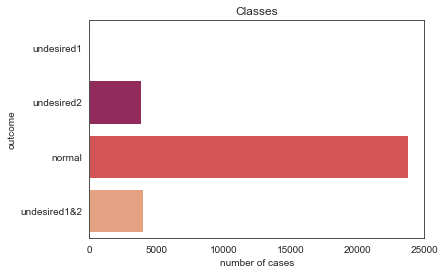

In [58]:
sns.set_style(style="white")
ax = sns.barplot(x=list(dictje.values()), y=list(dictje.keys()), palette="rocket")
ax.set(xlabel='number of cases', ylabel='outcome', title="Classes")